## 1. WDL





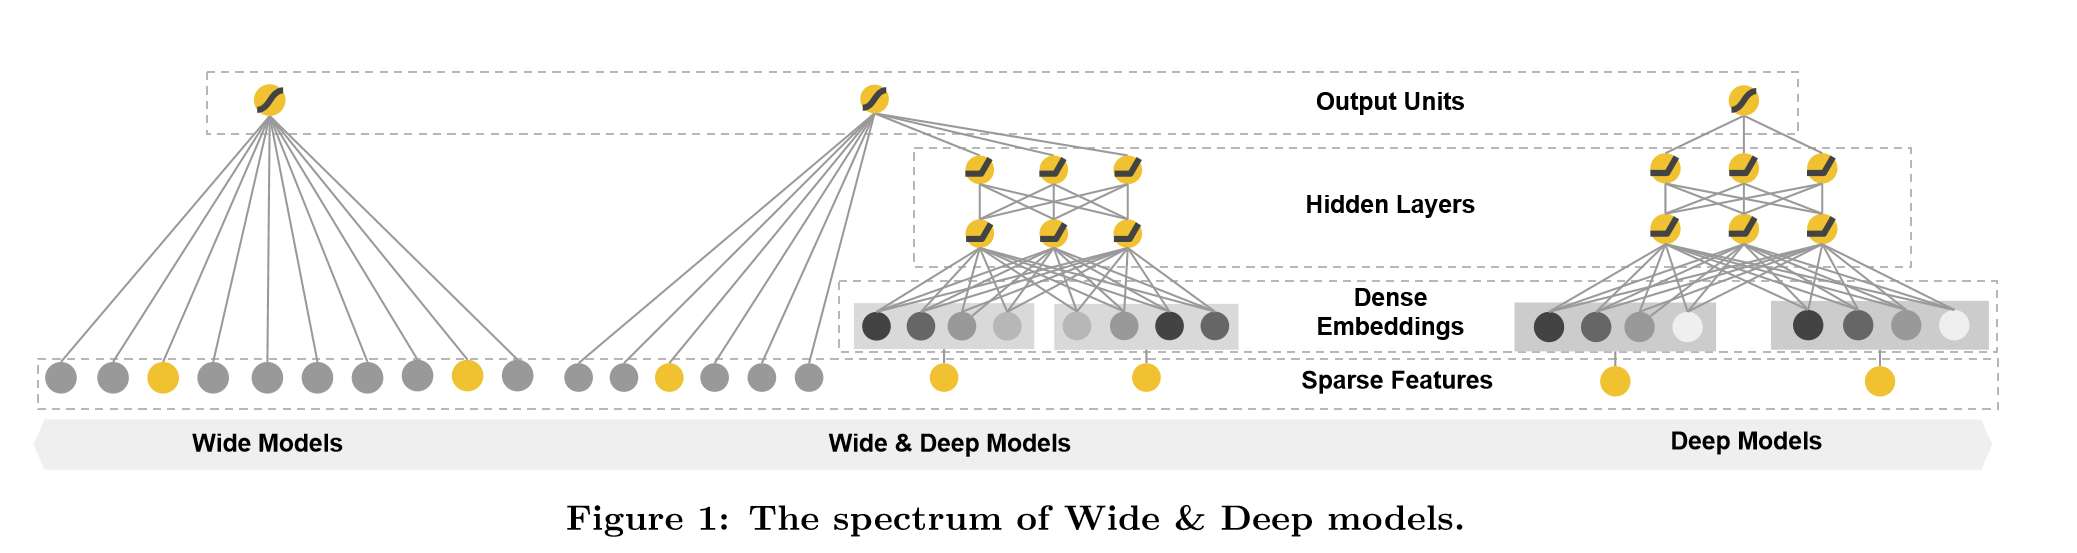

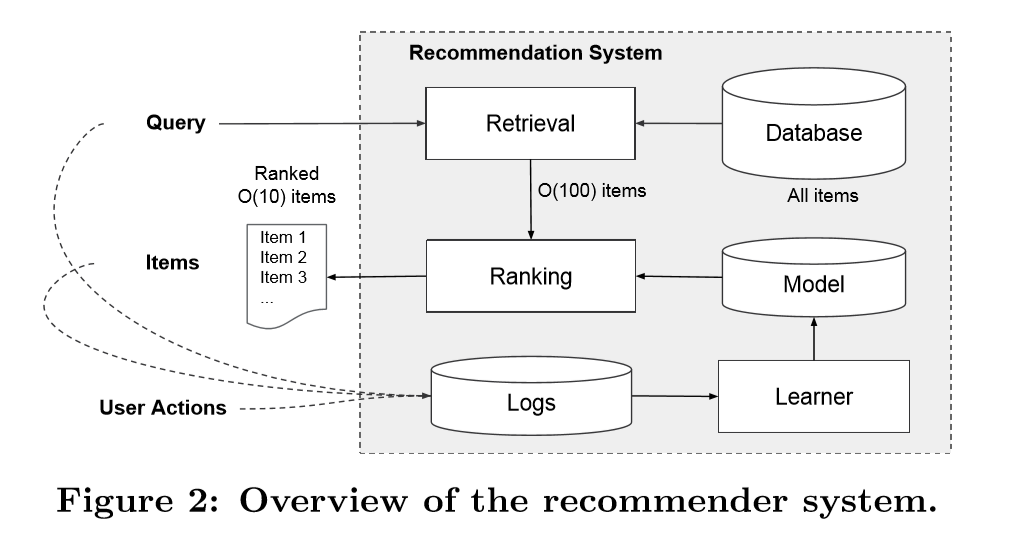

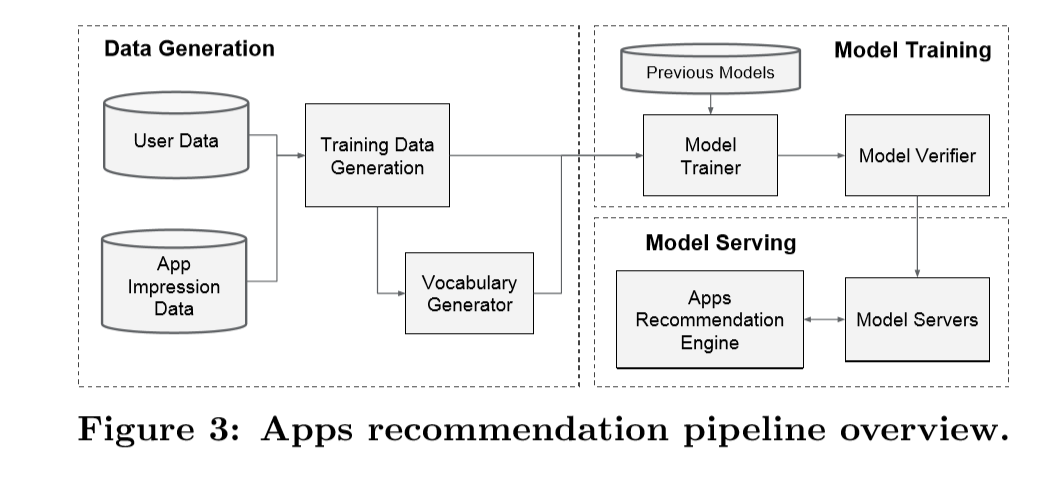

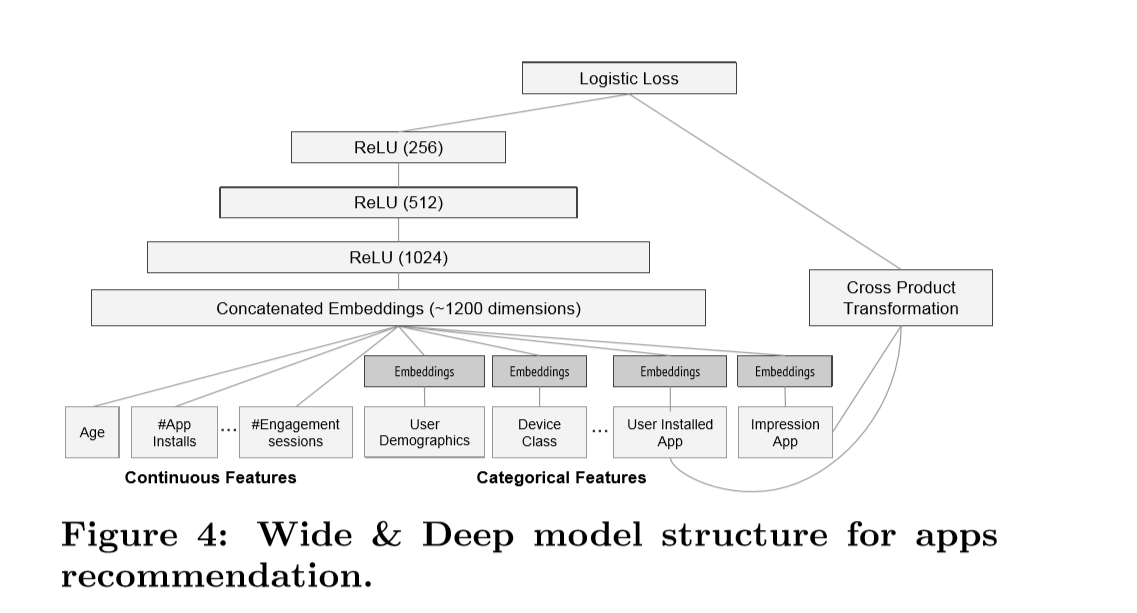

代码路径： code/model/tf_wdl_on_subsample.py

## 2.推荐系统 FM回顾

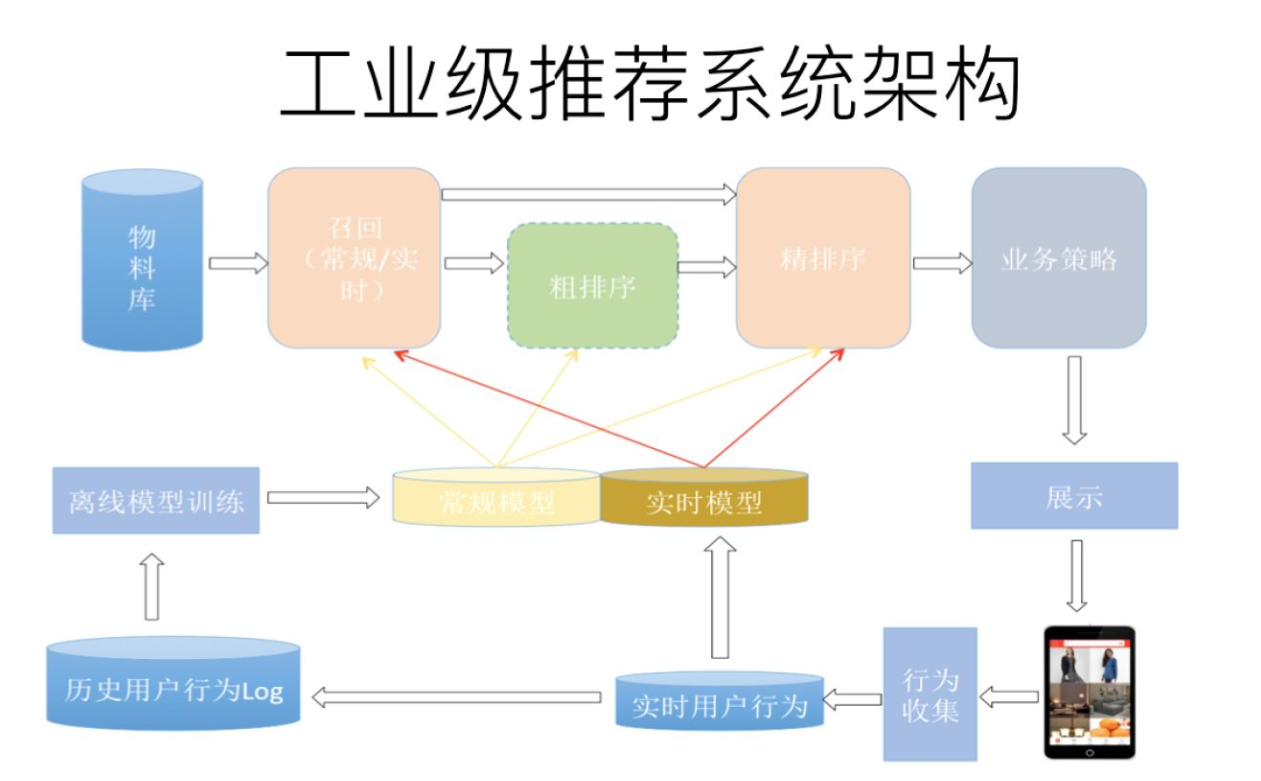

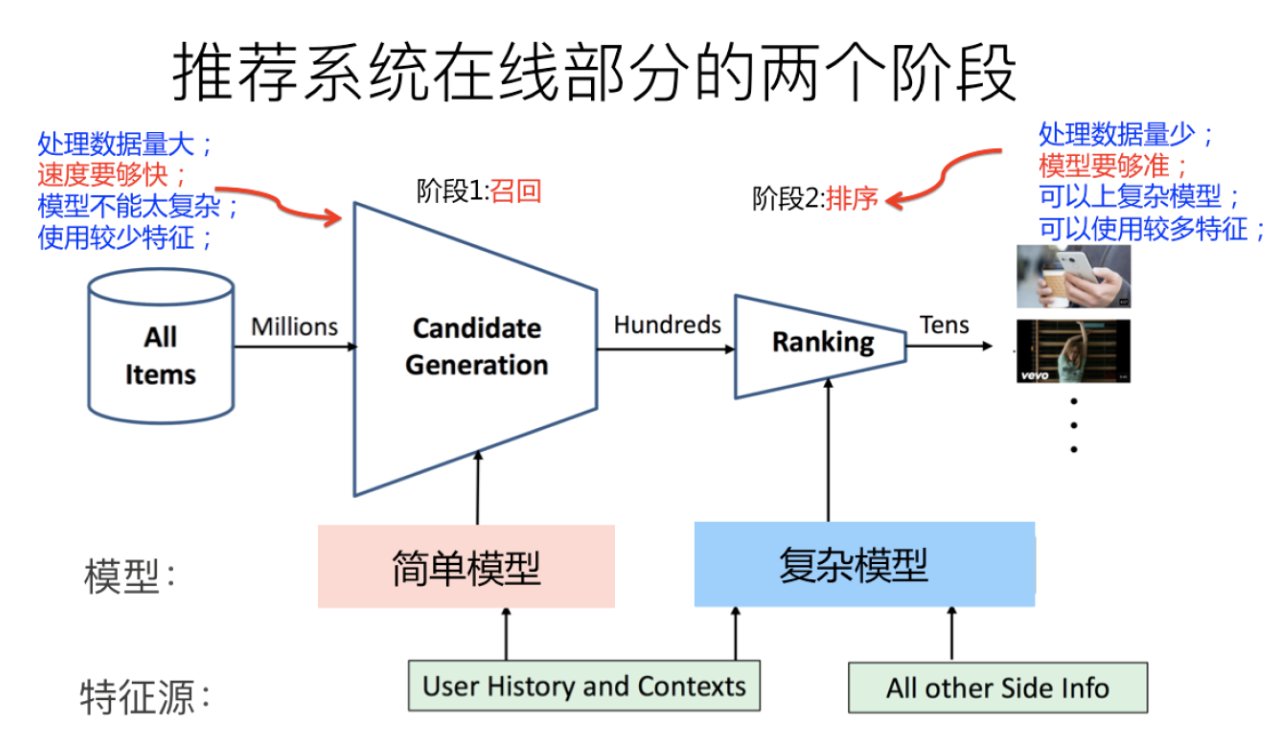

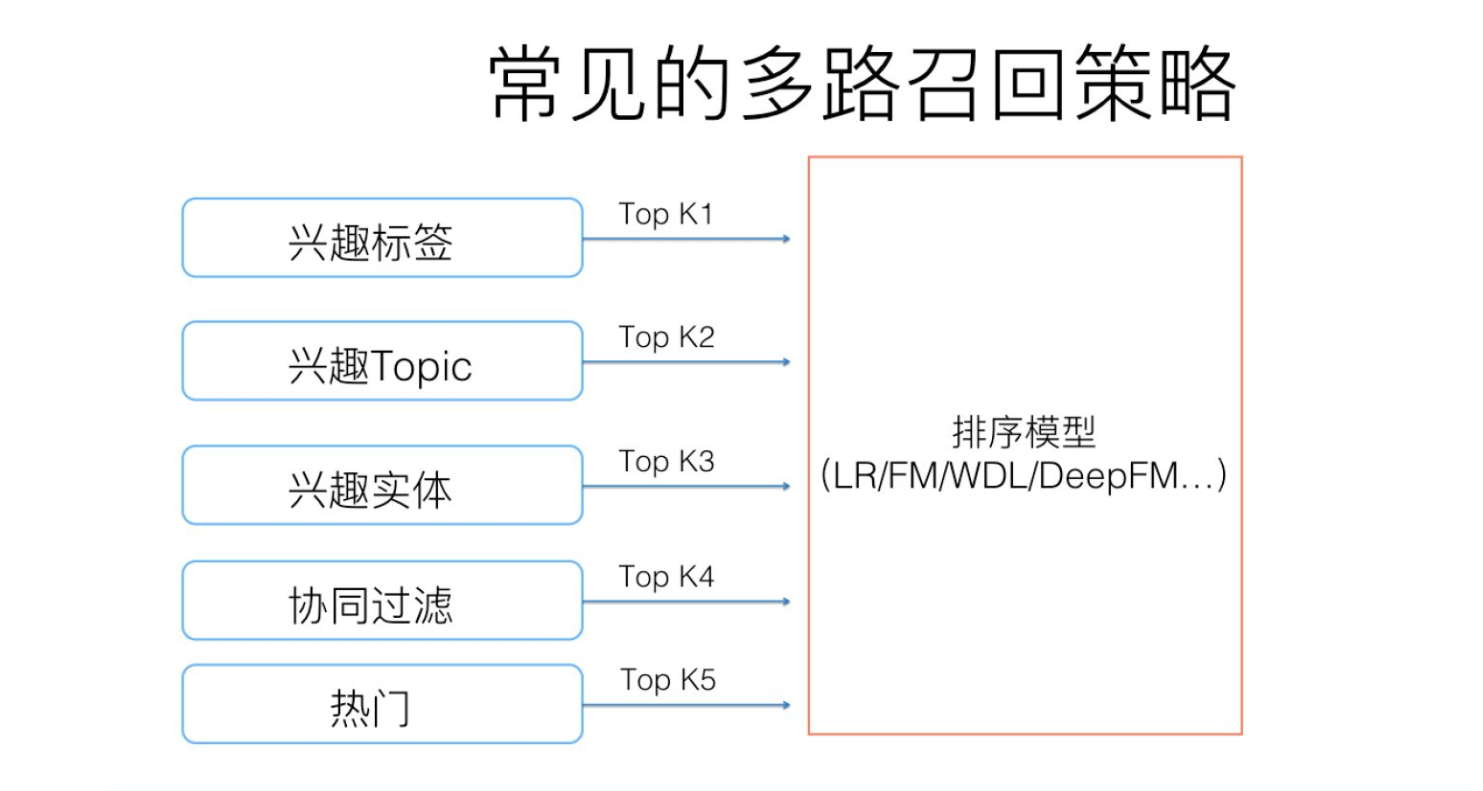

#### 从LR到FM模型

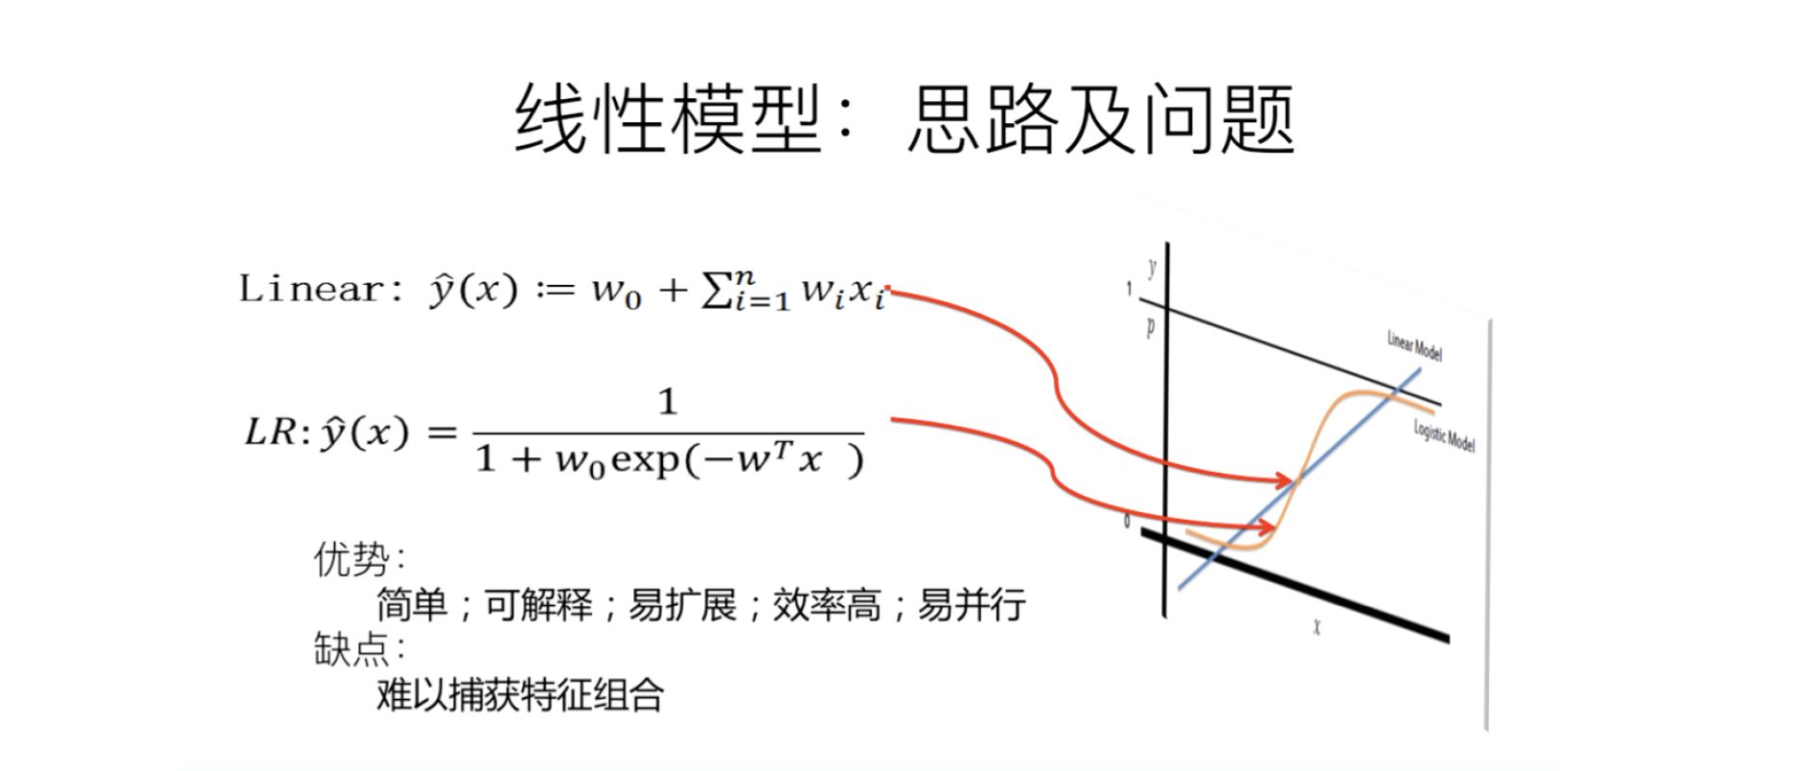

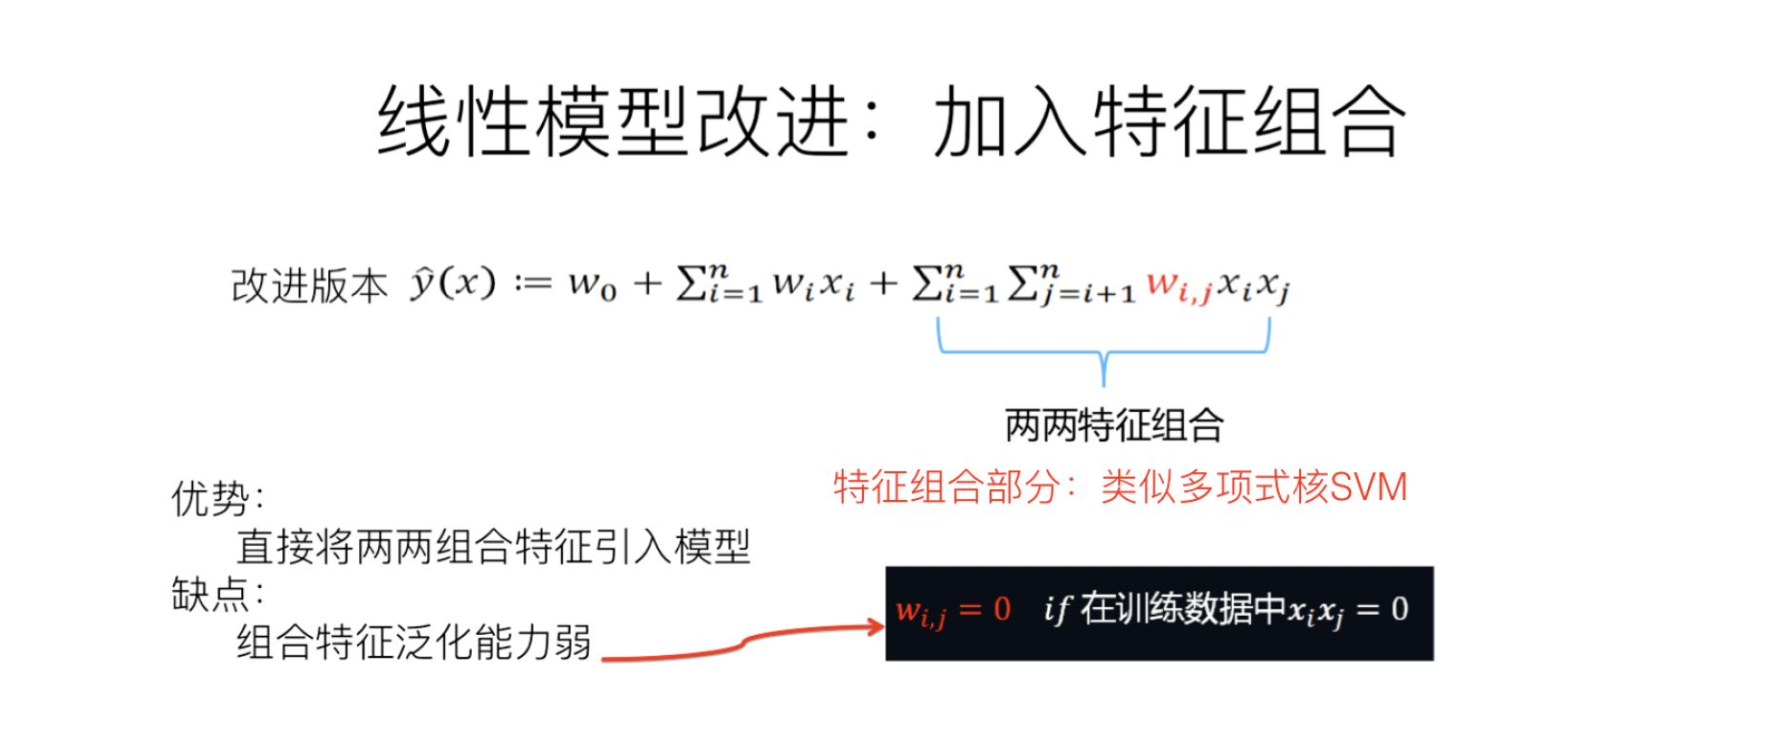

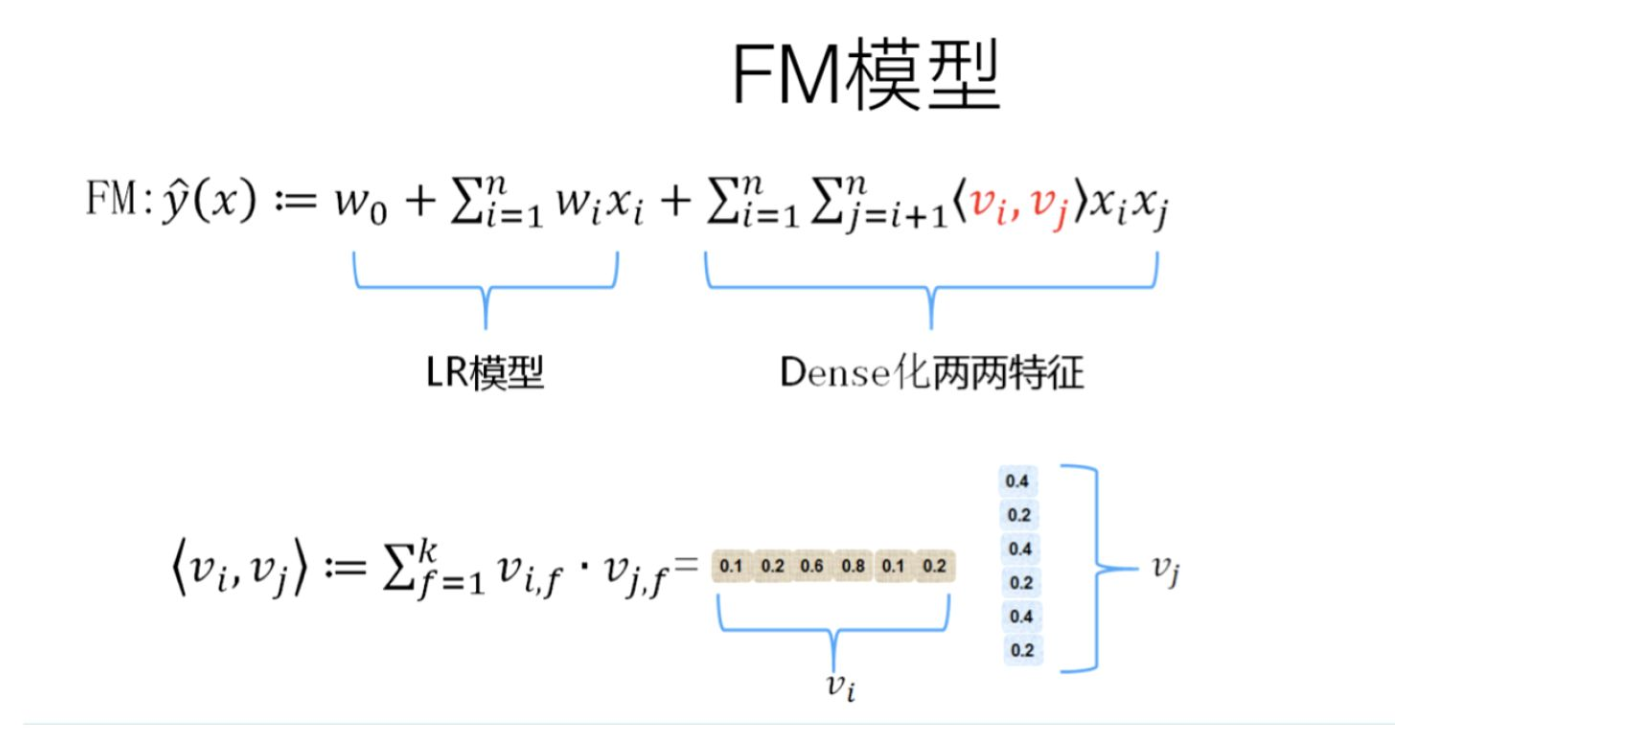

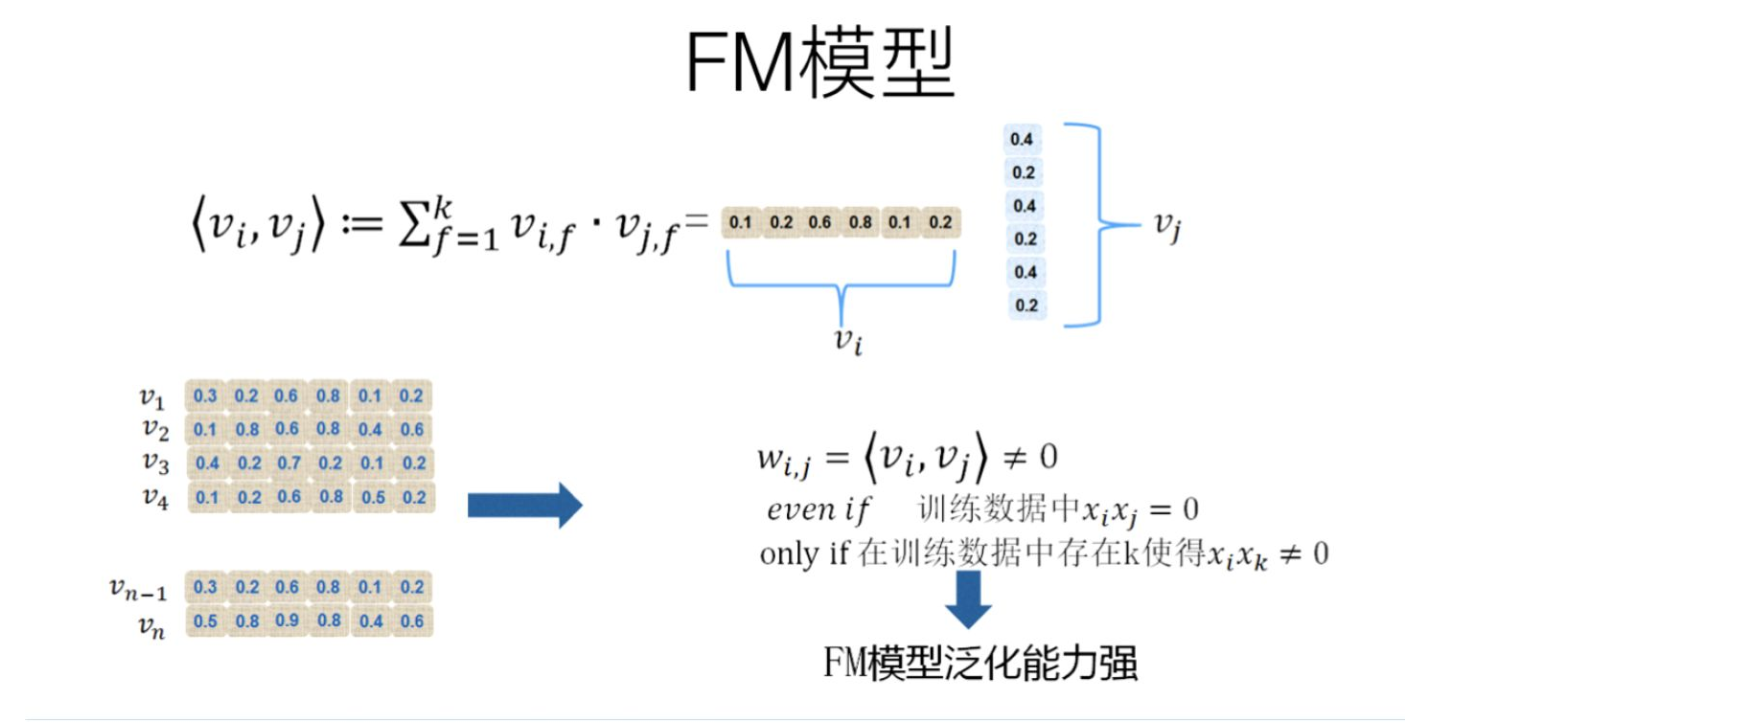

## 3. NFM 模型



主要贡献为：

1）首次在神经网络建模中引入了Bi-Interaction pooling operation，提出了一种新的FM的神经网络视角；

2）基于这种新的视角，NFM模型在神经网络框架下加深FM模型，用来学习更高阶和非线性的特征交互；

3）通过实验证明了NFM在稀疏场景下有效性；

其中，第一项和第二项是线性回归部分，与FM类似。第三项 f(x) 是NFM模型的核心部分，用于提取特征交互，是一个多层前向神经网络，如图2所示。

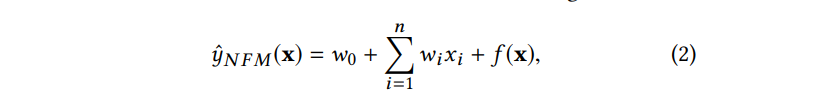

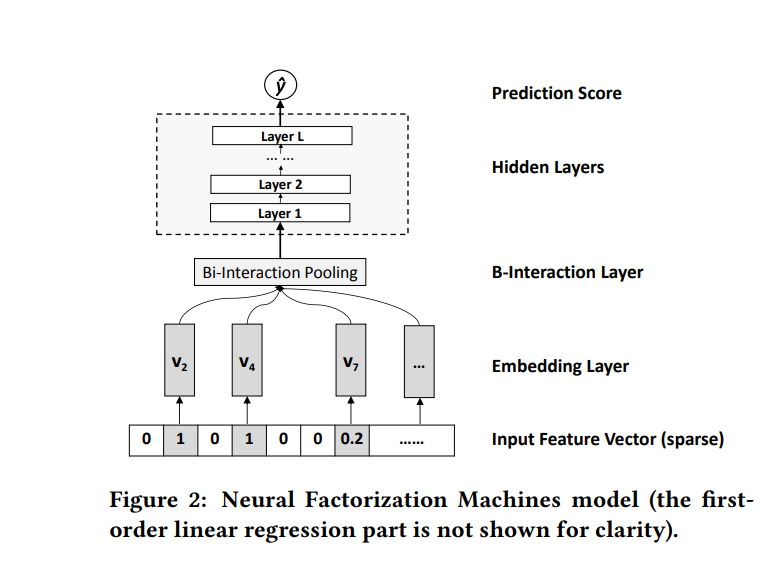

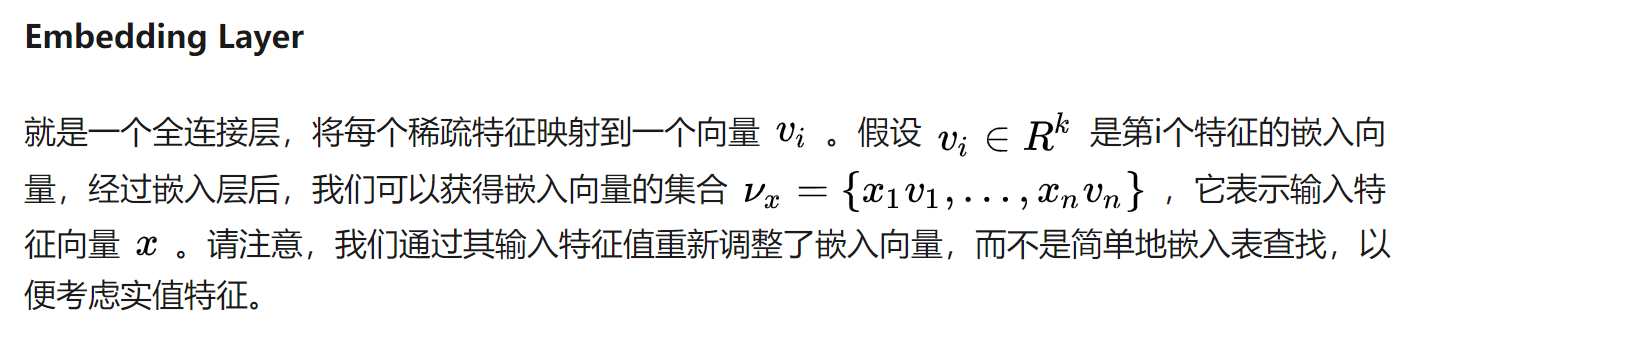

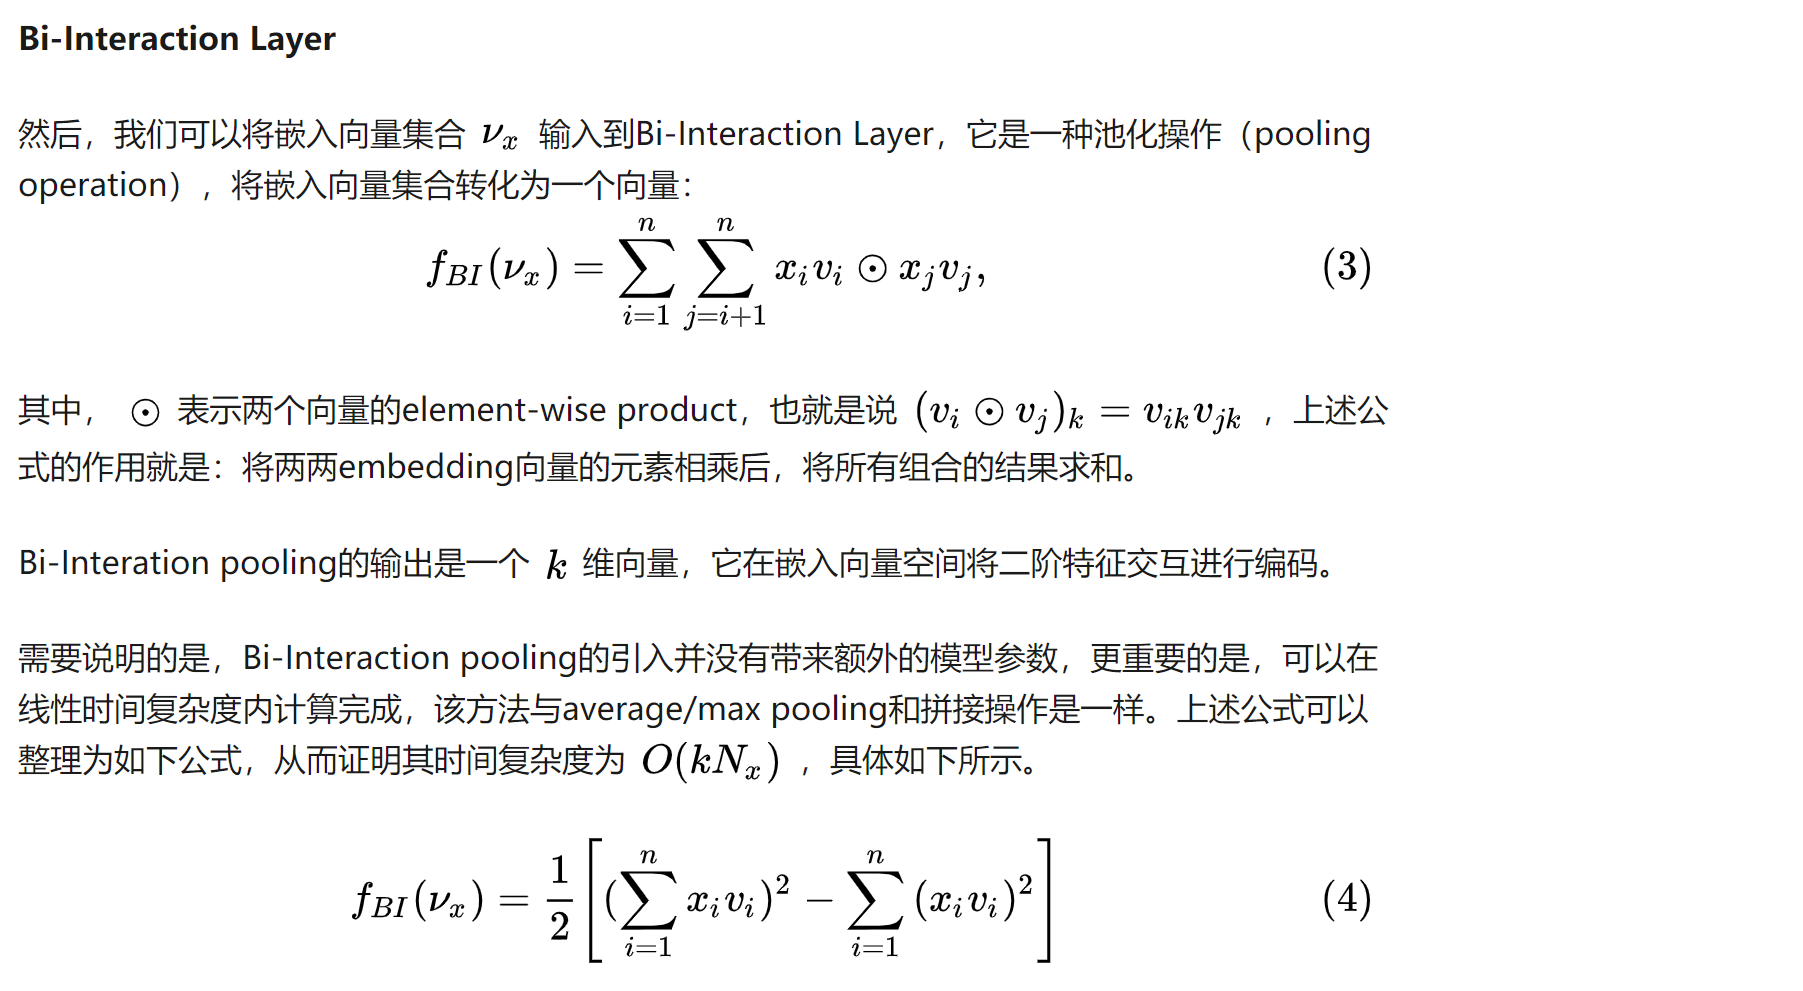

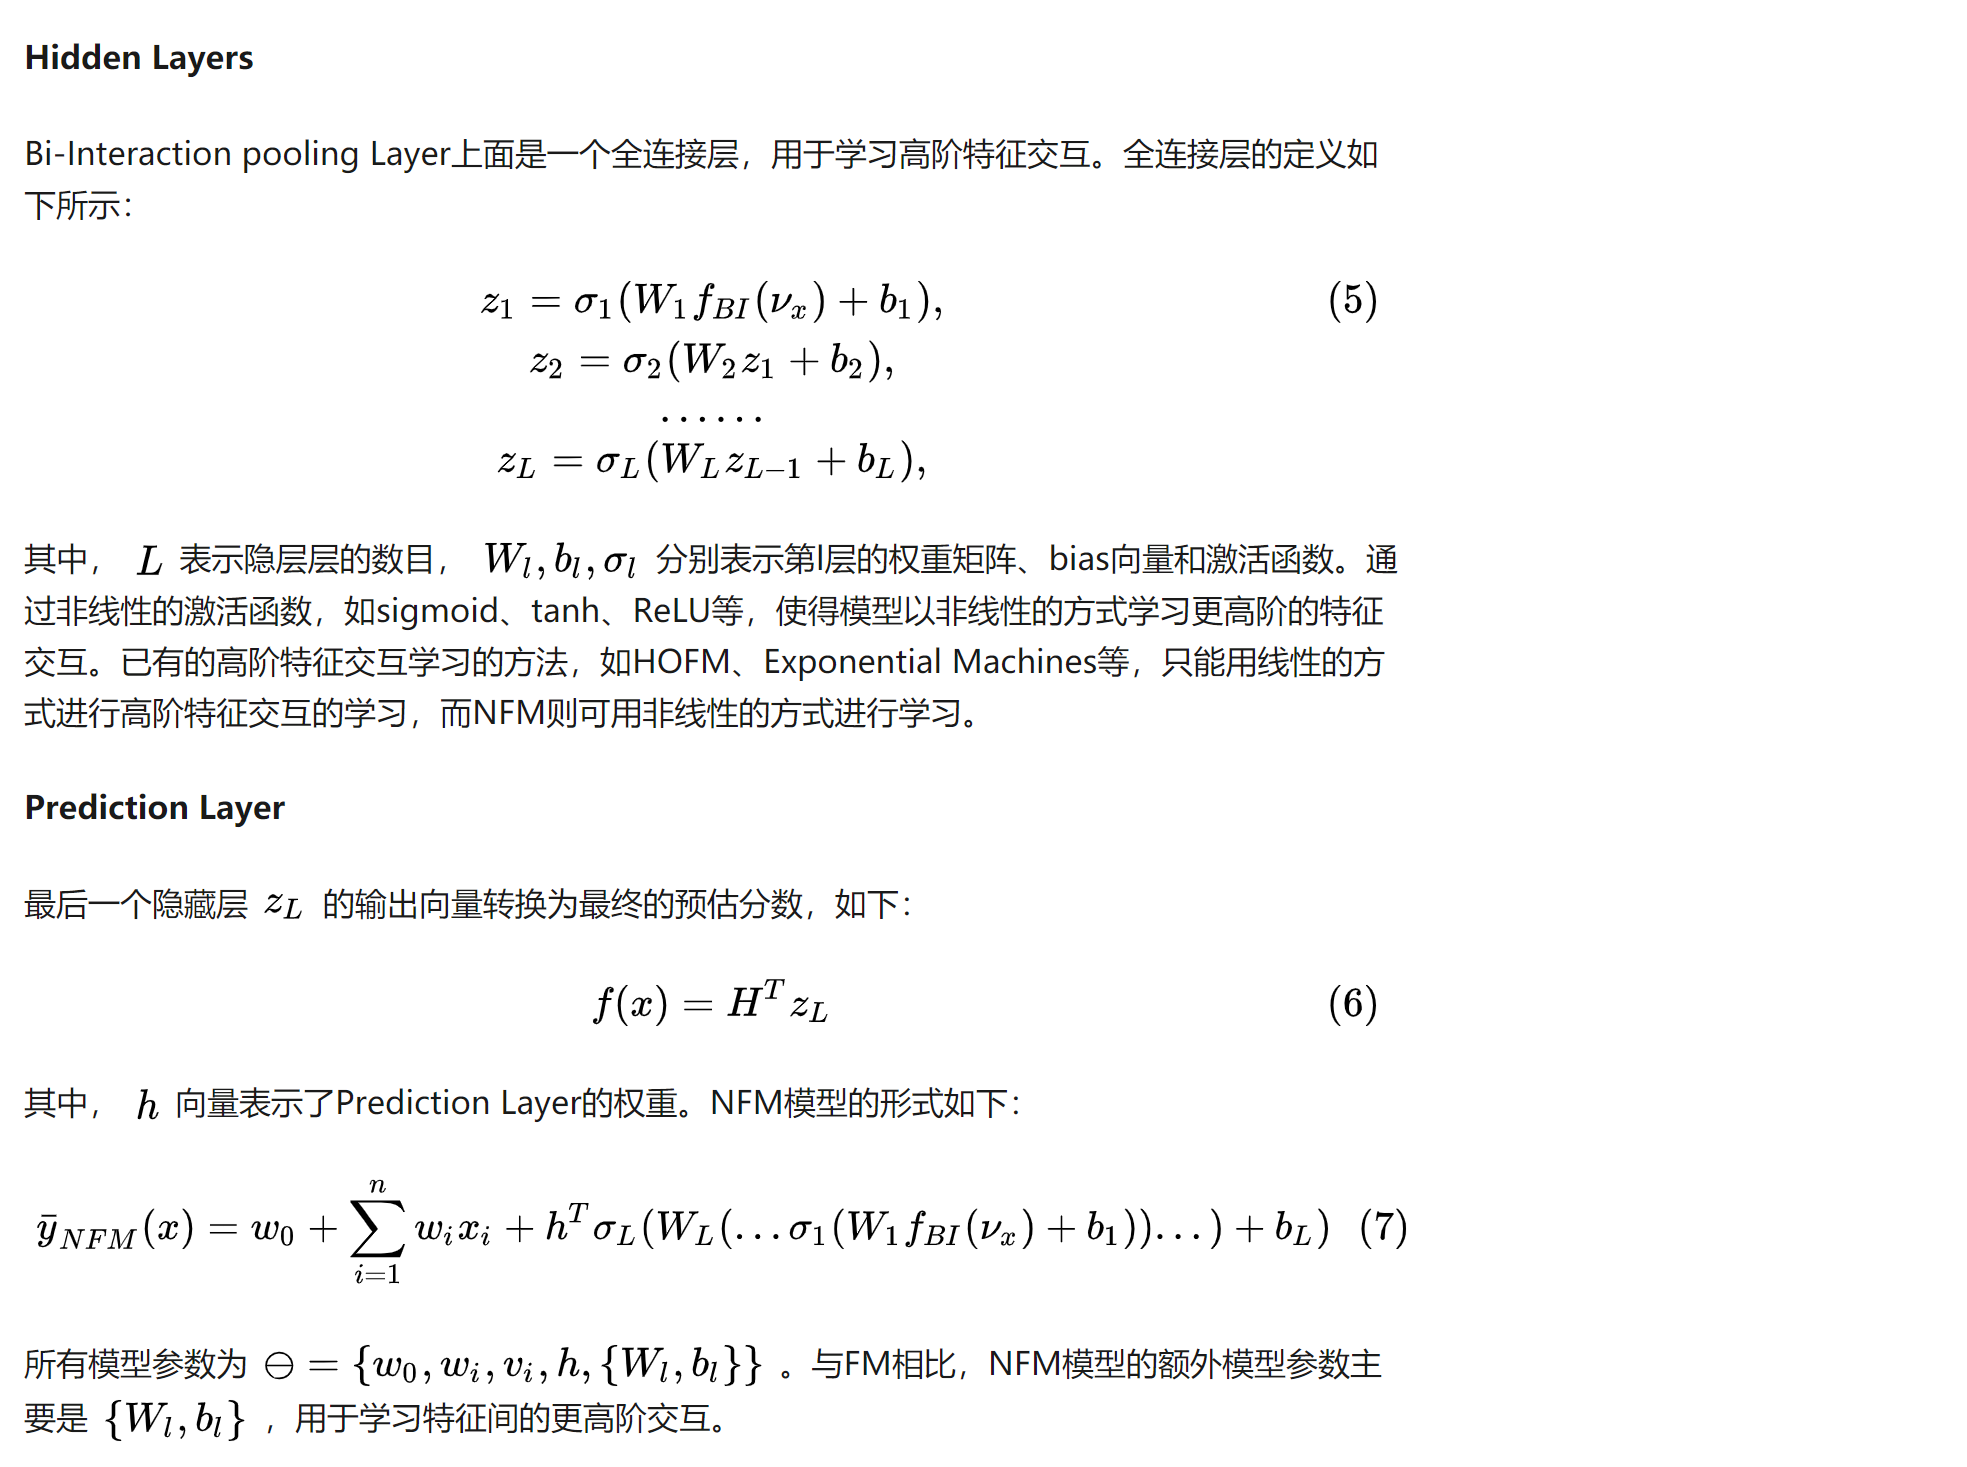

代码参考：code/model/NeuralFM.py

# WDL

In [1]:
'''
@thoughts:  as the samples are extremely imbalance (N/P ratio ~ 1.2k),
            here we use sub-sample on negative samples.
            1-st: using k_means to make clustering on negative samples (clusters_number ~ 1k)
            2-nd: subsample on each clusters based on the same ratio,
                  the ratio was selected to be the best by testing in random sub_sample + WDL
            ## 3-rd: selecting the best parameter for WDL classifier
            4-th: using WDL model for training and predicting on sub_sample set.
            
            here is 2-nd to 4-th step
'''

########## file path ##########
##### input file
# training set keys uic-label with k_means clusters' label
import itertools

from tensorflow.python.framework import dtypes
path_df_part_1_uic_label_cluster = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/df_part_1_uic_label_cluster.csv"
path_df_part_2_uic_label_cluster = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/df_part_2_uic_label_cluster.csv"
path_df_part_3_uic       = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/df_part_3_uic.csv"

# data_set features
path_df_part_1_U   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_1_U.csv"  
path_df_part_1_I   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_1_I.csv"
path_df_part_1_C   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_1_C.csv"
path_df_part_1_IC  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_1_IC.csv"
path_df_part_1_UI  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_1_UI.csv"
path_df_part_1_UC  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_1_UC.csv"

path_df_part_2_U   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_2_U.csv"  
path_df_part_2_I   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_2_I.csv"
path_df_part_2_C   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_2_C.csv"
path_df_part_2_IC  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_2_IC.csv"
path_df_part_2_UI  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_2_UI.csv"
path_df_part_2_UC  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_2_UC.csv"

path_df_part_3_U   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_3_U.csv"  
path_df_part_3_I   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_3_I.csv"
path_df_part_3_C   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_3_C.csv"
path_df_part_3_IC  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_3_IC.csv"
path_df_part_3_UI  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_3_UI.csv"
path_df_part_3_UC  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_3_UC.csv"

#item_sub_set P
path_df_P = '/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/tianchi_fresh_comp_train_item.csv'

### output files
path_df_result = '/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/wdl_res_wdl_k_means_subsample.csv'
path_df_result_tmp = '/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/wdl_df_result_tmp.csv'

In [2]:
# depending package
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
# some functions
def df_read(path, mode = 'r'):
    '''the definition of dataframe loading function 
    '''
    data_file = open(path, mode)
    try:     df = pd.read_csv(data_file, index_col = False)
    finally: data_file.close()
    return   df

def subsample(df, sub_size):
    '''the definition of sub-sampling function
    @param df: dataframe
    @param sub_size: sub_sample set size
    
    @return sub-dataframe with the same formation of df
    '''
    if sub_size >= len(df) : return df
    else : return df.sample(n = sub_size)

In [4]:
##### loading data of part 1 & 2
df_part_2_uic_label_cluster = df_read(path_df_part_2_uic_label_cluster)
df_part_1_uic_label_cluster = df_read(path_df_part_1_uic_label_cluster)

df_part_1_U  = df_read(path_df_part_1_U )   
df_part_1_I  = df_read(path_df_part_1_I )
df_part_1_C  = df_read(path_df_part_1_C )
df_part_1_IC = df_read(path_df_part_1_IC)
df_part_1_UI = df_read(path_df_part_1_UI)
df_part_1_UC = df_read(path_df_part_1_UC)

df_part_2_U  = df_read(path_df_part_2_U )   
df_part_2_I  = df_read(path_df_part_2_I )
df_part_2_C  = df_read(path_df_part_2_C )
df_part_2_IC = df_read(path_df_part_2_IC)
df_part_2_UI = df_read(path_df_part_2_UI)
df_part_2_UC = df_read(path_df_part_2_UC)

print("data loaded")

data loaded


In [5]:
DenseFeatureNames = ['u_b1_count_in_6','u_b2_count_in_6','u_b3_count_in_6','u_b4_count_in_6','u_b_count_in_6',
                     'u_b1_count_in_3','u_b2_count_in_3','u_b3_count_in_3','u_b4_count_in_3','u_b_count_in_3',
                     'u_b1_count_in_1','u_b2_count_in_1','u_b3_count_in_1','u_b4_count_in_1','u_b_count_in_1',
                     'u_b4_rate','u_b4_diff_hours',
                     'i_u_count_in_6','i_u_count_in_3','i_u_count_in_1',
                     'i_b1_count_in_6','i_b2_count_in_6','i_b3_count_in_6','i_b4_count_in_6','i_b_count_in_6',
                     'i_b1_count_in_3','i_b2_count_in_3','i_b3_count_in_3','i_b4_count_in_3','i_b_count_in_3',
                     'i_b1_count_in_1','i_b2_count_in_1','i_b3_count_in_1','i_b4_count_in_1','i_b_count_in_1',
                     'i_b4_rate','i_b4_diff_hours',
                     'c_u_count_in_6','c_u_count_in_3','c_u_count_in_1',
                     'c_b1_count_in_6','c_b2_count_in_6','c_b3_count_in_6','c_b4_count_in_6','c_b_count_in_6',
                     'c_b1_count_in_3','c_b2_count_in_3','c_b3_count_in_3','c_b4_count_in_3','c_b_count_in_3',
                     'c_b1_count_in_1','c_b2_count_in_1','c_b3_count_in_1','c_b4_count_in_1','c_b_count_in_1',
                     'c_b4_rate','c_b4_diff_hours',
                     'ic_u_rank_in_c','ic_b_rank_in_c','ic_b4_rank_in_c',
                     'ui_b1_count_in_6','ui_b2_count_in_6','ui_b3_count_in_6','ui_b4_count_in_6','ui_b_count_in_6',
                     'ui_b1_count_in_3','ui_b2_count_in_3','ui_b3_count_in_3','ui_b4_count_in_3','ui_b_count_in_3',
                     'ui_b1_count_in_1','ui_b2_count_in_1','ui_b3_count_in_1','ui_b4_count_in_1','ui_b_count_in_1',
                     'ui_b_count_rank_in_u','ui_b_count_rank_in_uc',
                     'ui_b1_last_hours','ui_b2_last_hours','ui_b3_last_hours','ui_b4_last_hours',
                     'uc_b1_count_in_6','uc_b2_count_in_6','uc_b3_count_in_6','uc_b4_count_in_6','uc_b_count_in_6',
                     'uc_b1_count_in_3','uc_b2_count_in_3','uc_b3_count_in_3','uc_b4_count_in_3','uc_b_count_in_3',
                     'uc_b1_count_in_1','uc_b2_count_in_1','uc_b3_count_in_1','uc_b4_count_in_1','uc_b_count_in_1',
                     'uc_b_count_rank_in_u',
                     'uc_b1_last_hours','uc_b2_last_hours','uc_b3_last_hours','uc_b4_last_hours']
SparseFeatureNames = ['user_id','item_id','item_category']
# we dont' have enough sparse features

In [6]:
Feature_Names = DenseFeatureNames + SparseFeatureNames

In [7]:
##### generation of training set & valid set
def train_set_construct(np_ratio = 1, sub_ratio = 1):
    '''
    # generation of train set
    @param np_ratio: int, the sub-sample rate of training set for N/P balanced.
    @param sub_ratio: float ~ (0~1], the further sub-sample rate of training set after N/P balanced.
    '''
    train_part_1_uic_label = df_part_1_uic_label_cluster[df_part_1_uic_label_cluster['class'] == 0].sample(frac = sub_ratio)
    train_part_2_uic_label = df_part_2_uic_label_cluster[df_part_2_uic_label_cluster['class'] == 0].sample(frac = sub_ratio)
    
    frac_ratio = sub_ratio * np_ratio/1200
    for i in range(1,1001,1):
        train_part_1_uic_label_0_i = df_part_1_uic_label_cluster[df_part_1_uic_label_cluster['class'] == i]
        train_part_1_uic_label_0_i = train_part_1_uic_label_0_i.sample(frac = frac_ratio)
        train_part_1_uic_label = pd.concat([train_part_1_uic_label, train_part_1_uic_label_0_i])
    
        train_part_2_uic_label_0_i = df_part_2_uic_label_cluster[df_part_2_uic_label_cluster['class'] == i]
        train_part_2_uic_label_0_i = train_part_2_uic_label_0_i.sample(frac = frac_ratio)
        train_part_2_uic_label = pd.concat([train_part_2_uic_label, train_part_2_uic_label_0_i])
    print("training subset uic_label keys is selected.")
    
    # constructing training set
    train_part_1_df = pd.merge(train_part_1_uic_label, df_part_1_U, how='left', on=['user_id'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_I,  how='left', on=['item_id'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_C,  how='left', on=['item_category'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_IC, how='left', on=['item_id','item_category'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_UI, how='left', on=['user_id','item_id','item_category','label'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_UC, how='left', on=['user_id','item_category'])
    
    train_part_2_df = pd.merge(train_part_2_uic_label, df_part_2_U, how='left', on=['user_id'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_I,  how='left', on=['item_id'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_C,  how='left', on=['item_category'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_IC, how='left', on=['item_id','item_category'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_UI, how='left', on=['user_id','item_id','item_category','label'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_UC, how='left', on=['user_id','item_category'])
    
    train_df = pd.concat([train_part_1_df, train_part_2_df])

    # fill the missing value as -1 (missing value are time features)
    train_df.fillna(-1, inplace=True)
    
    # # using all the features for training wdl model
    # train_X = train_df[Feature_Names].values
    # train_y = train_df['label'].values
    train_X = train_df[Feature_Names]
    train_y = train_df['label']
    print("train subset is generated.")
    return train_X, train_y

In [8]:
def valid_set_construct(sub_ratio = 0.1):
    '''
    # generation of valid set
    @param sub_ratio: float ~ (0~1], the sub-sample rate of original valid set
    '''
    valid_part_1_uic_label = df_part_1_uic_label_cluster[df_part_1_uic_label_cluster['class'] == 0].sample(frac = sub_ratio)
    valid_part_2_uic_label = df_part_2_uic_label_cluster[df_part_2_uic_label_cluster['class'] == 0].sample(frac = sub_ratio)

    for i in range(1,1001,1):
        valid_part_1_uic_label_0_i = df_part_1_uic_label_cluster[df_part_1_uic_label_cluster['class'] == i]
        valid_part_1_uic_label_0_i = valid_part_1_uic_label_0_i.sample(frac = sub_ratio)
        valid_part_1_uic_label = pd.concat([valid_part_1_uic_label, valid_part_1_uic_label_0_i])
    
        valid_part_2_uic_label_0_i = df_part_2_uic_label_cluster[df_part_2_uic_label_cluster['class'] == i]
        valid_part_2_uic_label_0_i = valid_part_2_uic_label_0_i.sample(frac = sub_ratio)
        valid_part_2_uic_label = pd.concat([valid_part_2_uic_label, valid_part_2_uic_label_0_i])
    
    # constructing valid set
    valid_part_1_df = pd.merge(valid_part_1_uic_label, df_part_1_U, how='left', on=['user_id'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_I,  how='left', on=['item_id'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_C,  how='left', on=['item_category'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_IC, how='left', on=['item_id','item_category'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_UI, how='left', on=['user_id','item_id','item_category','label'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_UC, how='left', on=['user_id','item_category'])
    
    valid_part_2_df = pd.merge(valid_part_2_uic_label, df_part_2_U, how='left', on=['user_id'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_I,  how='left', on=['item_id'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_C,  how='left', on=['item_category'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_IC, how='left', on=['item_id','item_category'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_UI, how='left', on=['user_id','item_id','item_category','label'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_UC, how='left', on=['user_id','item_category'])
    
    valid_df = pd.concat([valid_part_1_df, valid_part_2_df])

    # fill the missing value as -1 (missing value are time features)
    valid_df.fillna(-1, inplace=True)
    
    # using all the features for valid wdl model
    valid_X = valid_df[Feature_Names].values
    valid_y = valid_df['label'].values
    print("valid subset is generated.")
    return valid_X, valid_y

In [9]:
##### generation and splitting to training set & valid set
def valid_train_set_construct(valid_ratio = 0.5, valid_sub_ratio = 0.5, train_np_ratio = 1, train_sub_ratio = 0.5):
    '''
    # generation of train set
    @param valid_ratio: float ~ [0~1], the valid set ratio in total set and the rest is train set
    @param valid_sub_ratio: float ~ (0~1), random sample ratio of valid set
    @param train_np_ratio:(1~1200), the sub-sample ratio of training set for N/P balanced.
    @param train_sub_ratio: float ~ (0~1), random sample ratio of train set after N/P subsample
    
    @return valid_X, valid_y, train_X, train_y
    '''
    msk_1 = np.random.rand(len(df_part_1_uic_label_cluster)) < valid_ratio
    msk_2 = np.random.rand(len(df_part_2_uic_label_cluster)) < valid_ratio
        
    valid_df_part_1_uic_label_cluster = df_part_1_uic_label_cluster.loc[msk_1]
    valid_df_part_2_uic_label_cluster = df_part_2_uic_label_cluster.loc[msk_2]
    
    valid_part_1_uic_label = valid_df_part_1_uic_label_cluster[ valid_df_part_1_uic_label_cluster['class'] == 0 ].sample(frac = valid_sub_ratio)
    valid_part_2_uic_label = valid_df_part_2_uic_label_cluster[ valid_df_part_2_uic_label_cluster['class'] == 0 ].sample(frac = valid_sub_ratio)
    
    ### constructing valid set
    for i in range(1,1001,1):
        valid_part_1_uic_label_0_i = valid_df_part_1_uic_label_cluster[valid_df_part_1_uic_label_cluster['class'] == i]
        if len(valid_part_1_uic_label_0_i) != 0:
            valid_part_1_uic_label_0_i = valid_part_1_uic_label_0_i.sample(frac = valid_sub_ratio)
            valid_part_1_uic_label     = pd.concat([valid_part_1_uic_label, valid_part_1_uic_label_0_i])
        
        valid_part_2_uic_label_0_i = valid_df_part_2_uic_label_cluster[valid_df_part_2_uic_label_cluster['class'] == i]
        if len(valid_part_2_uic_label_0_i) != 0:
            valid_part_2_uic_label_0_i = valid_part_2_uic_label_0_i.sample(frac = valid_sub_ratio)
            valid_part_2_uic_label     = pd.concat([valid_part_2_uic_label, valid_part_2_uic_label_0_i])
    
    valid_part_1_df = pd.merge(valid_part_1_uic_label, df_part_1_U, how='left', on=['user_id'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_I,  how='left', on=['item_id'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_C,  how='left', on=['item_category'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_IC, how='left', on=['item_id','item_category'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_UI, how='left', on=['user_id','item_id','item_category','label'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_UC, how='left', on=['user_id','item_category'])
    
    valid_part_2_df = pd.merge(valid_part_2_uic_label, df_part_2_U, how='left', on=['user_id'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_I,  how='left', on=['item_id'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_C,  how='left', on=['item_category'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_IC, how='left', on=['item_id','item_category'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_UI, how='left', on=['user_id','item_id','item_category','label'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_UC, how='left', on=['user_id','item_category'])
    
    valid_df = pd.concat([valid_part_1_df, valid_part_2_df])

    # fill the missing value as -1 (missing value are time features)
    valid_df.fillna(-1, inplace=True)
    
    # using all the features for valid rf model
    valid_X = valid_df[Feature_Names].values
    valid_y = valid_df['label'].values
    print("valid subset is generated.")

    ### constructing training set
    train_df_part_1_uic_label_cluster = df_part_1_uic_label_cluster.loc[~msk_1]
    train_df_part_2_uic_label_cluster = df_part_2_uic_label_cluster.loc[~msk_2] 
    
    train_part_1_uic_label = train_df_part_1_uic_label_cluster[ train_df_part_1_uic_label_cluster['class'] == 0 ].sample(frac = train_sub_ratio)
    train_part_2_uic_label = train_df_part_2_uic_label_cluster[ train_df_part_2_uic_label_cluster['class'] == 0 ].sample(frac = train_sub_ratio)
    
    frac_ratio = train_sub_ratio * train_np_ratio/1200
    for i in range(1,1001,1):
        train_part_1_uic_label_0_i = train_df_part_1_uic_label_cluster[train_df_part_1_uic_label_cluster['class'] == i]
        if len(train_part_1_uic_label_0_i) != 0:
            train_part_1_uic_label_0_i = train_part_1_uic_label_0_i.sample(frac = frac_ratio)
            train_part_1_uic_label = pd.concat([train_part_1_uic_label, train_part_1_uic_label_0_i])
    
        train_part_2_uic_label_0_i = train_df_part_2_uic_label_cluster[train_df_part_2_uic_label_cluster['class'] == i]
        if len(train_part_2_uic_label_0_i) != 0:
            train_part_2_uic_label_0_i = train_part_2_uic_label_0_i.sample(frac = frac_ratio)
            train_part_2_uic_label = pd.concat([train_part_2_uic_label, train_part_2_uic_label_0_i])
    
    # constructing training set
    train_part_1_df = pd.merge(train_part_1_uic_label, df_part_1_U, how='left', on=['user_id'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_I,  how='left', on=['item_id'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_C,  how='left', on=['item_category'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_IC, how='left', on=['item_id','item_category'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_UI, how='left', on=['user_id','item_id','item_category','label'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_UC, how='left', on=['user_id','item_category'])
    
    train_part_2_df = pd.merge(train_part_2_uic_label, df_part_2_U, how='left', on=['user_id'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_I,  how='left', on=['item_id'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_C,  how='left', on=['item_category'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_IC, how='left', on=['item_id','item_category'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_UI, how='left', on=['user_id','item_id','item_category','label'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_UC, how='left', on=['user_id','item_category'])
    
    train_df = pd.concat([train_part_1_df, train_part_2_df])

    # fill the missing value as -1 (missing value are time features)
    train_df.fillna(-1, inplace=True)
    
    # using all the features for training rf model
    train_X = train_df[Feature_Names].values
    train_y = train_df['label'].values
    print("train subset is generated.")
    
    return valid_X, valid_y, train_X, train_y

In [11]:
'''Step 2: training the optimal wdl model and predicting on part_3 
'''
train_X, train_y = train_set_construct(np_ratio=60, sub_ratio=1)
print(train_X.info())
print(train_X.dtypes)
print(train_y.dtypes)
print('train set done')

training subset uic_label keys is selected.
train subset is generated.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 179251 entries, 0 to 92426
Columns: 104 entries, u_b1_count_in_6 to item_category
dtypes: float64(14), int64(90)
memory usage: 143.6 MB
None
u_b1_count_in_6       int64
u_b2_count_in_6       int64
u_b3_count_in_6       int64
u_b4_count_in_6       int64
u_b_count_in_6        int64
                     ...   
uc_b3_last_hours    float64
uc_b4_last_hours    float64
user_id               int64
item_id               int64
item_category         int64
Length: 104, dtype: object
int64
train set done


In [13]:
valid_X, valid_y = valid_set_construct(sub_ratio = 0.1)

valid subset is generated.


In [11]:
# build WDL model and fitting
# 其实我们构造的特征多数都是实数值，并没有太多sparse特征，所以并不一定适合WDL；这里只是为了说明用法
def build_model_columns():
    """Builds a set of wide and deep feature columns."""
    # Continuous variable columns
    wide_columns = []  # 类别特征、类别交叉特征
    deep_columns = []   # 数值特征、类别特征one-hot、Embedding

#     用户约 18252
#     SparseFeatureNames = ['user_id','item_id','item_category']
#     user_id = tf.feature_column.categorical_column_with_hash_bucket('user_id', hash_bucket_size=19000, dtype=dtypes.int64)
#     商品约 1262961
#     item_id = tf.feature_column.categorical_column_with_hash_bucket('item_id', hash_bucket_size=1270000, dtype=dtypes.int64)
#     商品类别约 7814
    item_category = tf.feature_column.categorical_column_with_hash_bucket('item_category', hash_bucket_size=8000, dtype=dtypes.int64)
    # # class约 1001；不能用，因为prediction的时候没有
    # classfea = tf.feature_column.categorical_column_with_hash_bucket('class', hash_bucket_size=1001, dtype=dtypes.int64)

    # 词表 类别特征例子
    # education = tf.feature_column.categorical_column_with_vocabulary_list(
    #     'education', [
    #         'Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
    #         'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
    #         '5th-6th', '10th', '1st-4th', 'Preschool', '12th'])
    # 分组特征例子
    # age_buckets = tf.feature_column.bucketized_column(
    #     age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
    # 交叉特征例子
    # tf.feature_column.crossed_column(['education', 'occupation'], hash_bucket_size=_HASH_BUCKET_SIZE)

    wide_columns += [
        # user_id,
                     # item_id,
                     item_category
                     ]

    # 实数值特征
    for fea in DenseFeatureNames:
        deep_columns.append(
            tf.feature_column.numeric_column(fea)
        )
    #  类别特征 indicator 例子
    # tf.feature_column.indicator_column(relationship),
    #  Embedding
    deep_columns += [
    #     tf.feature_column.embedding_column(user_id, dimension=6),
    #     # tf.feature_column.embedding_column(item_id, dimension=8),
        tf.feature_column.embedding_column(item_category, dimension=4)
    ]

    return wide_columns, deep_columns

In [12]:
# model
def build_wdl_model(wide_columns,deep_columns):
    estimator =  tf.estimator.DNNLinearCombinedClassifier(
        model_dir='/Users/DanDan/Desktop/第一课/code/_tf_model',
        # wide settings
        linear_feature_columns=wide_columns,
        linear_optimizer='Ftrl',
        # deep settings
        dnn_feature_columns=deep_columns,
        dnn_hidden_units=[128, 10, 4],
        dnn_optimizer='Adagrad')

    # To apply L1 and L2 regularization, you can set dnn_optimizer to:
    tf.compat.v1.train.ProximalAdagradOptimizer(
        learning_rate=0.01,
        l1_regularization_strength=0.001,
        l2_regularization_strength=0.001)
    # To apply learning rate decay, you can set dnn_optimizer to a callable:
    # lambda: tf.keras.optimizers.Adam(
    #     learning_rate=tf.compat.v1.train.exponential_decay(
    #         learning_rate=0.1,
    #         global_step=tf.compat.v1.train.get_global_step(),
    #         decay_steps=10000,
    #         decay_rate=0.96))
    return estimator

wide_columns, deep_columns = build_model_columns()
estimator = build_wdl_model(wide_columns, deep_columns)

# Input builders
def input_fn_train(train_X,train_y,num_epochs):
    # Returns tf.data.Dataset of (x, y) tuple where y represents label's class
    # index.
    return tf.compat.v1.estimator.inputs.pandas_input_fn(
        x=pd.DataFrame({k: train_X[k].values for k in Feature_Names}),
        y = pd.Series(train_y.values),
        num_epochs=num_epochs,
        shuffle=False)

print('model constructed，start training')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/Users/DanDan/Desktop/第一课/code/_tf_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
model constructed，start training


In [13]:
wide_columns, deep_columns = build_model_columns()
estimator = build_wdl_model(wide_columns, deep_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/Users/DanDan/Desktop/第一课/code/_tf_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [14]:
# Input builders
def input_fn_train(train_X,train_y,num_epochs):
    # Returns tf.data.Dataset of (x, y) tuple where y represents label's class
    # index.
    return tf.compat.v1.estimator.inputs.pandas_input_fn(
        x=pd.DataFrame({k: train_X[k].values for k in Feature_Names}),
        y = pd.Series(train_y.values),
        num_epochs=num_epochs,
        shuffle=False)
print('Model constructed Start train')

Model constructed Start train


In [17]:
# train
estimator.train(input_fn=input_fn_train(train_X,train_y,num_epochs=2), steps=10)
print('Train done, start prediction')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /Users/DanDan/Desktop/第一课/code/_tf_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 65.931946, step = 0
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 10...
INFO:tensorflow:Saving checkpoints for 10 into /Users/DanDan/Desktop/第一课/code/_tf_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 10...
INFO:tensorflow:Loss for final step: 0.26055798.
Train done, start prediction


In [18]:
##### predicting
# loading feature data
df_part_3_U  = df_read(path_df_part_3_U )   
df_part_3_I  = df_read(path_df_part_3_I )
df_part_3_C  = df_read(path_df_part_3_C )
df_part_3_IC = df_read(path_df_part_3_IC)
df_part_3_UI = df_read(path_df_part_3_UI)
df_part_3_UC = df_read(path_df_part_3_UC)
# pred_uic = df_read(path_df_part_3_uic).head(1000)
pred_uic = df_read(path_df_part_3_uic)

In [19]:
def test_set_construct():
    pred_df = pd.merge(pred_uic, df_part_3_U,  how='left', on=['user_id'])
    pred_df = pd.merge(pred_df,  df_part_3_I,  how='left', on=['item_id'])
    pred_df = pd.merge(pred_df,  df_part_3_C,  how='left', on=['item_category'])
    pred_df = pd.merge(pred_df,  df_part_3_IC, how='left', on=['item_id','item_category'])
    pred_df = pd.merge(pred_df,  df_part_3_UI, how='left', on=['user_id','item_id','item_category'])
    pred_df = pd.merge(pred_df,  df_part_3_UC, how='left', on=['user_id','item_category'])

    # fill the missing value as -1 (missing value are time features)
    pred_df.fillna(-1, inplace=True)

    # # using all the features for training wdl model
    # train_X = train_df[Feature_Names].values
    # train_y = train_df['label'].values
    pred_X = pred_df[Feature_Names]
    print("测试样本生成完成.")
    return pred_X

def input_fn_predict(pred_X):
    # Returns tf.data.Dataset of (x, None) tuple.
    # dataset = tf.data.Dataset.from_tensor_slices(dict(pred_X))
    # dataset = dataset.batch(10240)
    # return dataset
    return tf.compat.v1.estimator.inputs.pandas_input_fn(
        x=pd.DataFrame({k: pred_X[k].values for k in Feature_Names}),
        y = None,
        num_epochs=1,
        batch_size = 1024,
        shuffle=False)
pred_X = test_set_construct()
pred_y = estimator.predict(input_fn=input_fn_predict(pred_X))

print(pred_y)
# for pred_y_data in pred_y:
#     print(pred_y_data)
#     break
# pred_y_data = next(pred_y)
# print(pred_y_data)
print(pred_X.shape)
# pred_y_data = list(itertools.islice(pred_y,10))
# pred_y_data = [p["classes"] for p in pred_y]

pred_y_data = []
for p in pred_y:
    if len(pred_y_data) % 10000 == 0:
        print('预测进度', len(pred_y_data))
    # pred_y_data.append(p["classes"][0])
    pred_y_data.append(p['logistic'][0])
    # break
pred_y_data = pd.DataFrame(pred_y_data)
print(pred_y_data.head(10))

# generation of U-I pairs those predicted to buy
pred_X['pred_label'] = (pred_y_data > 0.5).astype(int)
# pred_X['pred_label'] = pred_y_data
print(pred_X[['user_id','item_id','pred_label']].head(30))
# add to result csv
pred_X[pred_X['pred_label'] == 1 ].to_csv(path_df_result_tmp,
                                         columns=['user_id','item_id'],
                                         index=False, header=False, mode='w')
# pred_X.to_csv(path_df_result_tmp,
#                                          columns=['user_id','item_id'],
#                                          index=False, header=False, mode='a')
print("预测结束")

测试样本生成完成.
<generator object Estimator.predict at 0x7f829d3c4c10>
(1833627, 104)
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /Users/DanDan/Desktop/第一课/code/_tf_model/model.ckpt-10
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
预测进度 0
预测进度 10000
预测进度 20000
预测进度 30000
预测进度 40000
预测进度 50000
预测进度 60000
预测进度 70000
预测进度 80000
预测进度 90000
预测进度 100000
预测进度 110000
预测进度 120000
预测进度 130000
预测进度 140000
预测进度 150000
预测进度 160000
预测进度 170000
预测进度 180000
预测进度 190000
预测进度 200000
预测进度 210000
预测进度 220000
预测进度 230000
预测进度 240000
预测进度 250000
预测进度 260000
预测进度 270000
预测进度 280000
预测进度 290000
预测进度 300000
预测进度 310000
预测进度 320000
预测进度 330000
预测进度 340000
预测进度 350000
预测进度 360000
预测进度 370000
预测进度 380000
预测进度 390000
预测进度 400000
预测进度 410000
预测进度 420000
预测进度 430000
预测进度 440000
预测进度 450000
预测进度 460000
预测进度 470000
预测进度 480000
预测进度 490000
预测进度 500000
预测进度 510000
预测进度 520000
预测进度 530

In [20]:
#######################################################################
'''Step 3: generation result on items' sub set P
'''
# loading data
df_P = df_read(path_df_P)
df_P_item = df_P.drop_duplicates(['item_id'])[['item_id']]
df_pred = pd.read_csv(open(path_df_result_tmp,'r'), index_col=False, header=None)
df_pred.columns = ['user_id', 'item_id']

# output result
df_pred_P = pd.merge(df_pred, df_P_item, on=['item_id'], how='inner')[['user_id', 'item_id']]
df_pred_P.to_csv(path_df_result, index=False)

print(' Finished。 ')

 Finished。 


# NFM

说明：因为数据的稀疏度不够，用WDL和NFM等模型很难做出优秀的预测，因此NFM代码可尝试，结果并不理想

In [14]:
'''
class NeuralFM 的代码实现

'''

import numpy as np
import os

class LoadData(object):
    # Three files are needed in the path
    def __init__(self, train, test, loss_type):
        self.trainfile = self.train_X
        self.validationfile = self.train_y
        self.features_M = self.map_features( )
        self.Train_data, self.Validation_data = self.construct_data( loss_type )

    def map_features(self): # map the feature entries in all files, kept in self.features dictionary
        self.features = {}
        self.read_features(self.trainfile)
        self.read_features(self.validationfile)
        #print("features_M:", len(self.features))
        return  len(self.features)

    def read_features(self, file): # read a feature file
        f = open( file )
        line = f.readline()
        i = len(self.features)
        while line:
            items = line.strip().split(' ')
            for item in items[1:]:
                if item not in self.features:
                    self.features[ item ] = i
                    i = i + 1
            line = f.readline()
        f.close()

    def construct_data(self, loss_type):
        X_, Y_ , Y_for_logloss= self.read_data(self.trainfile)
        if loss_type == 'log_loss':
            Train_data = self.construct_dataset(X_, Y_for_logloss)
        else:
            Train_data = self.construct_dataset(X_, Y_)
        print("# of training:" , len(Y_))

        X_, Y_ , Y_for_logloss= self.read_data(self.validationfile)
        if loss_type == 'log_loss':
            Validation_data = self.construct_dataset(X_, Y_for_logloss)
        else:
            Validation_data = self.construct_dataset(X_, Y_)
        print("# of validation:", len(Y_))


        return Train_data,  Validation_data

    def read_data(self, file):
        # read a data file. For a row, the first column goes into Y_;
        # the other columns become a row in X_ and entries are maped to indexs in self.features
        f = open( file )
        X_ = []
        Y_ = []
        Y_for_logloss = []
        line = f.readline()
        while line:
            items = line.strip().split(' ')
            Y_.append( 1.0*float(items[0]) )

            if float(items[0]) > 0:# > 0 as 1; others as 0
                v = 1.0
            else:
                v = 0.0
            Y_for_logloss.append( v )

            X_.append( [ self.features[item] for item in items[1:]] )
            line = f.readline()
        f.close()
        return X_, Y_, Y_for_logloss

    def construct_dataset(self, X_, Y_):
        Data_Dic = {}
        X_lens = [ len(line) for line in X_]
        indexs = np.argsort(X_lens)
        Data_Dic['Y'] = [ Y_[i] for i in indexs]
        Data_Dic['X'] = [ X_[i] for i in indexs]
        return Data_Dic
    
    def truncate_features(self):
        """
        Make sure each feature vector is of the same length
        """
        num_variable = len(self.Train_data['X'][0])
        for i in xrange(len(self.Train_data['X'])):
            num_variable = min([num_variable, len(self.Train_data['X'][i])])
        # truncate train, validation and test
        for i in xrange(len(self.Train_data['X'])):
            self.Train_data['X'][i] = self.Train_data['X'][i][0:num_variable]
        for i in xrange(len(self.Validation_data['X'])):
            self.Validation_data['X'][i] = self.Validation_data['X'][i][0:num_variable]
        return num_variable

In [15]:
import os
import sys
import math
import numpy as np
import tensorflow as tf
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from time import time
import argparse

In [17]:
# import data as DATA
# from tensorflow.contrib.layers.python.layers import batch_norm as batch_norm

#################### Arguments ####################
def parse_args():
    parser = argparse.ArgumentParser(description="Run Neural FM.")
    parser.add_argument('--path', nargs='?', default='data/',
                        help='Input data path.')
    parser.add_argument('--dataset', nargs='?', default='frappe',
                        help='Choose a dataset.')
    parser.add_argument('--epoch', type=int, default=200,
                        help='Number of epochs.')
    parser.add_argument('--pretrain', type=int, default=0,
                        help='Pre-train flag. 0: train from scratch; 1: load from pretrain file')
    parser.add_argument('--batch_size', type=int, default=128,
                        help='Batch size.')
    parser.add_argument('--hidden_factor', type=int, default=64,
                        help='Number of hidden factors.')
    parser.add_argument('--layers', nargs='?', default='[64]',
                        help="Size of each layer.")
    parser.add_argument('--keep_prob', nargs='?', default='[0.8,0.5]',
                        help='Keep probability (i.e., 1-dropout_ratio) for each deep layer and the Bi-Interaction layer. 1: no dropout. Note that the last index is for the Bi-Interaction layer.')
    parser.add_argument('--lamda', type=float, default=0,
                        help='Regularizer for bilinear part.')
    parser.add_argument('--lr', type=float, default=0.05,
                        help='Learning rate.')
    parser.add_argument('--loss_type', nargs='?', default='square_loss',
                        help='Specify a loss type (square_loss or log_loss).')
    parser.add_argument('--optimizer', nargs='?', default='AdagradOptimizer',
                        help='Specify an optimizer type (AdamOptimizer, AdagradOptimizer, GradientDescentOptimizer, MomentumOptimizer).')
    parser.add_argument('--verbose', type=int, default=1,
                        help='Show the results per X epochs (0, 1 ... any positive integer)')
    parser.add_argument('--batch_norm', type=int, default=1,
                    help='Whether to perform batch normaization (0 or 1)')
    parser.add_argument('--activation', nargs='?', default='relu',
                    help='Which activation function to use for deep layers: relu, sigmoid, tanh, identity')
    parser.add_argument('--early_stop', type=int, default=1,
                    help='Whether to perform early stop (0 or 1)')
    return parser.parse_args()

In [18]:
class NeuralFM(BaseEstimator, TransformerMixin):
    def __init__(self, features_M, hidden_factor, layers, loss_type, pretrain_flag, epoch, batch_size, learning_rate, lamda_bilinear,
                 keep_prob, optimizer_type, batch_norm, activation_function, verbose, early_stop, random_seed=2016):
        # bind params to class
        self.batch_size = batch_size
        self.hidden_factor = hidden_factor
        self.layers = layers
        self.loss_type = loss_type
        self.pretrain_flag = pretrain_flag
        self.features_M = features_M
        self.lamda_bilinear = lamda_bilinear
        self.epoch = epoch
        self.random_seed = random_seed
        self.keep_prob = np.array(keep_prob)
        self.no_dropout = np.array([1 for i in xrange(len(keep_prob))])
        self.optimizer_type = optimizer_type
        self.learning_rate = learning_rate
        self.batch_norm = batch_norm
        self.verbose = verbose
        self.activation_function = activation_function
        self.early_stop = early_stop
        # performance of each epoch
        self.train_rmse, self.valid_rmse, self.test_rmse = [], [], []

        # init all variables in a tensorflow graph
        self._init_graph()

    def _init_graph(self):
        '''
        Init a tensorflow Graph containing: input data, variables, model, loss, optimizer
        '''
        self.graph = tf.Graph()
        with self.graph.as_default():  # , tf.device('/cpu:0'):
            # Set graph level random seed
            tf.set_random_seed(self.random_seed)
            # Input data.
            self.train_features = tf.placeholder(tf.int32, shape=[None, None])  # None * features_M
            self.train_labels = tf.placeholder(tf.float32, shape=[None, 1])  # None * 1
            self.dropout_keep = tf.placeholder(tf.float32, shape=[None])
            self.train_phase = tf.placeholder(tf.bool)

            # Variables.
            self.weights = self._initialize_weights()

            # Model.
            # _________ sum_square part _____________
            # get the summed up embeddings of features.
            # (1)构建embedding
            nonzero_embeddings = tf.nn.embedding_lookup(self.weights['feature_embeddings'], self.train_features)
            # 先求和再平方
            self.summed_features_emb = tf.reduce_sum(nonzero_embeddings, 1) # None * K
            # get the element-multiplication
            self.summed_features_emb_square = tf.square(self.summed_features_emb)  # None * K

            # 先平方 再求和
            # _________ square_sum part _____________
            self.squared_features_emb = tf.square(nonzero_embeddings)
            self.squared_sum_features_emb = tf.reduce_sum(self.squared_features_emb, 1)  # None * K

            # ________ FM __________
            # (2) 以 求和平方 减去 平方的求和，除以二
            self.FM = 0.5 * tf.sub(self.summed_features_emb_square, self.squared_sum_features_emb)  # None * K

            if self.batch_norm:
                self.FM = self.batch_norm_layer(self.FM, train_phase=self.train_phase, scope_bn='bn_fm')
            self.FM = tf.nn.dropout(self.FM, self.dropout_keep[-1]) # dropout at the bilinear interactin layer

            # ________ Deep Layers __________
            # (3) 接入 神经网络模型
            for i in range(0, len(self.layers)):
                # 全连接中的：w*x + b
                self.FM = tf.add(tf.matmul(self.FM, self.weights['layer_%d' %i]), self.weights['bias_%d'%i]) # None * layer[i] * 1
                if self.batch_norm:
                    self.FM = self.batch_norm_layer(self.FM, train_phase=self.train_phase, scope_bn='bn_%d' %i) # None * layer[i] * 1
                # 加入激活函数
                self.FM = self.activation_function(self.FM)
                self.FM = tf.nn.dropout(self.FM, self.dropout_keep[i]) # dropout at each Deep layer
            self.FM = tf.matmul(self.FM, self.weights['prediction'])     # None * 1

            # _________out _________
            # (4) 加入 NFM的线性部分
            # 对应 f(x)
            Bilinear = tf.reduce_sum(self.FM, 1, keep_dims=True)  # None * 1

            # 线性部分：求和
            self.Feature_bias = tf.reduce_sum(tf.nn.embedding_lookup(self.weights['feature_bias'], self.train_features) , 1)  # None * 1
            # 线性部分：b
            Bias = self.weights['bias'] * tf.ones_like(self.train_labels)  # None * 1

            self.out = tf.add_n([Bilinear, self.Feature_bias, Bias])  # None * 1

            # Compute the loss.
            if self.loss_type == 'square_loss':
                if self.lamda_bilinear > 0:
                    self.loss = tf.nn.l2_loss(tf.sub(self.train_labels, self.out)) + tf.contrib.layers.l2_regularizer(self.lamda_bilinear)(self.weights['feature_embeddings'])  # regulizer
                else:
                    self.loss = tf.nn.l2_loss(tf.sub(self.train_labels, self.out))
            elif self.loss_type == 'log_loss':
                self.out = tf.sigmoid(self.out)
                if self.lambda_bilinear > 0:
                    self.loss = tf.contrib.losses.log_loss(self.out, self.train_labels, weight=1.0, epsilon=1e-07, scope=None) + tf.contrib.layers.l2_regularizer(self.lamda_bilinear)(self.weights['feature_embeddings'])  # regulizer
                else:
                    self.loss = tf.contrib.losses.log_loss(self.out, self.train_labels, weight=1.0, epsilon=1e-07, scope=None)

            # Optimizer.
            if self.optimizer_type == 'AdamOptimizer':
                self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8).minimize(self.loss)
            elif self.optimizer_type == 'AdagradOptimizer':
                self.optimizer = tf.train.AdagradOptimizer(learning_rate=self.learning_rate, initial_accumulator_value=1e-8).minimize(self.loss)
            elif self.optimizer_type == 'GradientDescentOptimizer':
                self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate).minimize(self.loss)
            elif self.optimizer_type == 'MomentumOptimizer':
                self.optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate, momentum=0.95).minimize(self.loss)

            # init
            # 构建session
            self.saver = tf.train.Saver()
            init = tf.global_variables_initializer()
            self.sess = tf.Session()
            self.sess.run(init)

            # number of params
            total_parameters = 0
            for variable in self.weights.values():
                shape = variable.get_shape() # shape is an array of tf.Dimension
                variable_parameters = 1
                for dim in shape:
                    variable_parameters *= dim.value
                total_parameters += variable_parameters
            if self.verbose > 0:
                print("#params: %d" %total_parameters)

    def _initialize_weights(self):
        all_weights = dict()
        if self.pretrain_flag > 0: # with pretrain
            pretrain_file = '../pretrain/%s_%d/%s_%d' %(args.dataset, args.hidden_factor, args.dataset, args.hidden_factor)
            weight_saver = tf.train.import_meta_graph(pretrain_file + '.meta')
            pretrain_graph = tf.get_default_graph()
            feature_embeddings = pretrain_graph.get_tensor_by_name('feature_embeddings:0')
            feature_bias = pretrain_graph.get_tensor_by_name('feature_bias:0')
            bias = pretrain_graph.get_tensor_by_name('bias:0')
            with tf.Session() as sess:
                weight_saver.restore(sess, pretrain_file)
                fe, fb, b = sess.run([feature_embeddings, feature_bias, bias])
            all_weights['feature_embeddings'] = tf.Variable(fe, dtype=tf.float32)
            all_weights['feature_bias'] = tf.Variable(fb, dtype=tf.float32)
            all_weights['bias'] = tf.Variable(b, dtype=tf.float32)
        else: # without pretrain
            all_weights['feature_embeddings'] = tf.Variable(
                tf.random_normal([self.features_M, self.hidden_factor], 0.0, 0.01), name='feature_embeddings')  # features_M * K
            all_weights['feature_bias'] = tf.Variable(tf.random_uniform([self.features_M, 1], 0.0, 0.0), name='feature_bias')  # features_M * 1
            all_weights['bias'] = tf.Variable(tf.constant(0.0), name='bias')  # 1 * 1
        # deep layers
        num_layer = len(self.layers)
        if num_layer > 0:
            glorot = np.sqrt(2.0 / (self.hidden_factor + self.layers[0]))
            all_weights['layer_0'] = tf.Variable(np.random.normal(loc=0, scale=glorot, size=(self.hidden_factor, self.layers[0])), dtype=np.float32)
            all_weights['bias_0'] = tf.Variable(np.random.normal(loc=0, scale=glorot, size=(1, self.layers[0])), dtype=np.float32)  # 1 * layers[0]
            for i in range(1, num_layer):
                glorot = np.sqrt(2.0 / (self.layers[i-1] + self.layers[i]))
                all_weights['layer_%d' %i] = tf.Variable(
                    np.random.normal(loc=0, scale=glorot, size=(self.layers[i-1], self.layers[i])), dtype=np.float32)  # layers[i-1]*layers[i]
                all_weights['bias_%d' %i] = tf.Variable(
                    np.random.normal(loc=0, scale=glorot, size=(1, self.layers[i])), dtype=np.float32)  # 1 * layer[i]
	        # prediction layer
            glorot = np.sqrt(2.0 / (self.layers[-1] + 1))
            all_weights['prediction'] = tf.Variable(np.random.normal(loc=0, scale=glorot, size=(self.layers[-1], 1)), dtype=np.float32)  # layers[-1] * 1
        else:
            all_weights['prediction'] = tf.Variable(np.ones((self.hidden_factor, 1), dtype=np.float32))  # hidden_factor * 1
        return all_weights

    def batch_norm_layer(self, x, train_phase, scope_bn):
        bn_train = batch_norm(x, decay=0.9, center=True, scale=True, updates_collections=None,
            is_training=True, reuse=None, trainable=True, scope=scope_bn)
        bn_inference = batch_norm(x, decay=0.9, center=True, scale=True, updates_collections=None,
            is_training=False, reuse=True, trainable=True, scope=scope_bn)
        z = tf.cond(train_phase, lambda: bn_train, lambda: bn_inference)
        return z

    def partial_fit(self, data):  # fit a batch
        feed_dict = {self.train_features: data['X'], self.train_labels: data['Y'], self.dropout_keep: self.keep_prob, self.train_phase: True}
        loss, opt = self.sess.run((self.loss, self.optimizer), feed_dict=feed_dict)
        return loss

    def get_random_block_from_data(self, data, batch_size):  # generate a random block of training data
        start_index = np.random.randint(0, len(data['Y']) - batch_size)
        X , Y = [], []
        # forward get sample
        i = start_index
        while len(X) < batch_size and i < len(data['X']):
            if len(data['X'][i]) == len(data['X'][start_index]):
                Y.append([data['Y'][i]])
                X.append(data['X'][i])
                i = i + 1
            else:
                break
        # backward get sample
        i = start_index
        while len(X) < batch_size and i >= 0:
            if len(data['X'][i]) == len(data['X'][start_index]):
                Y.append([data['Y'][i]])
                X.append(data['X'][i])
                i = i - 1
            else:
                break
        return {'X': X, 'Y': Y}

    def shuffle_in_unison_scary(self, a, b):
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)

    def train(self, Train_data, Validation_data, Test_data):  # fit a dataset
        # Check Init performance
        if self.verbose > 0:
            t2 = time()
            init_train = self.evaluate(Train_data)
            init_valid = self.evaluate(Validation_data)
            init_test = self.evaluate(Test_data)
            print("Init: \t train=%.4f, validation=%.4f, test=%.4f [%.1f s]" %(init_train, init_valid, init_test, time()-t2))

        for epoch in xrange(self.epoch):
            t1 = time()
            self.shuffle_in_unison_scary(Train_data['X'], Train_data['Y'])
            total_batch = int(len(Train_data['Y']) / self.batch_size)
            for i in xrange(total_batch):
                # generate a batch
                batch_xs = self.get_random_block_from_data(Train_data, self.batch_size)
                # Fit training
                self.partial_fit(batch_xs)
            t2 = time()
            
            # output validation
            train_result = self.evaluate(Train_data)
            valid_result = self.evaluate(Validation_data)
            test_result = self.evaluate(Test_data)
            
            self.train_rmse.append(train_result)
            self.valid_rmse.append(valid_result)
            self.test_rmse.append(test_result)
            if self.verbose > 0 and epoch%self.verbose == 0:
                print("Epoch %d [%.1f s]\ttrain=%.4f, validation=%.4f, test=%.4f [%.1f s]" 
                      %(epoch+1, t2-t1, train_result, valid_result, test_result, time()-t2))
            if self.early_stop > 0 and self.eva_termination(self.valid_rmse):
                #print "Early stop at %d based on validation result." %(epoch+1)
                break

    def eva_termination(self, valid):
        if self.loss_type == 'square_loss':
            if len(valid) > 5:
                if valid[-1] > valid[-2] and valid[-2] > valid[-3] and valid[-3] > valid[-4] and valid[-4] > valid[-5]:
                    return True
        else:
            if len(valid) > 5:
                if valid[-1] < valid[-2] and valid[-2] < valid[-3] and valid[-3] < valid[-4] and valid[-4] < valid[-5]:
                    return True
        return False

    def evaluate(self, data):  # evaluate the results for an input set
        num_example = len(data['Y'])
        feed_dict = {self.train_features: data['X'], self.train_labels: [[y] for y in data['Y']], self.dropout_keep: self.no_dropout, self.train_phase: False}
        
        # 执行训练
        predictions = self.sess.run((self.out), feed_dict=feed_dict)  
        
        y_pred = np.reshape(predictions, (num_example,))
        y_true = np.reshape(data['Y'], (num_example,))
        if self.loss_type == 'square_loss':    
            predictions_bounded = np.maximum(y_pred, np.ones(num_example) * min(y_true))  # bound the lower values
            predictions_bounded = np.minimum(predictions_bounded, np.ones(num_example) * max(y_true))  # bound the higher values
            RMSE = math.sqrt(mean_squared_error(y_true, predictions_bounded))
            return RMSE
        elif self.loss_type == 'log_loss':
            logloss = log_loss(y_true, y_pred) # I haven't checked the log_loss
            return logloss

In [19]:
if __name__ == '__main__':
    # Data loading
    # 1. 数据读取
    args = parse_args()
    data = DATA.LoadData(args.path, args.dataset, args.loss_type) # 读数据
    if args.verbose > 0:
        print("Neural FM: dataset=%s, hidden_factor=%d, dropout_keep=%s, layers=%s, loss_type=%s, pretrain=%d, #epoch=%d, batch=%d, lr=%.4f, lambda=%.4f, optimizer=%s, batch_norm=%d, activation=%s, early_stop=%d"
              %(args.dataset, args.hidden_factor, args.keep_prob, args.layers, args.loss_type, args.pretrain, args.epoch, args.batch_size, args.lr, args.lamda, args.optimizer, args.batch_norm, args.activation, args.early_stop))
    activation_function = tf.nn.relu
    if args.activation == 'sigmoid':
        activation_function = tf.sigmoid
    elif args.activation == 'tanh':
        activation_function == tf.tanh
    elif args.activation == 'identity':
        activation_function = tf.identity

    # Training
    t1 = time()
    # 2.模型训练
    # 2.1 构建graph （包括embedding）
    model = NeuralFM(data.features_M, args.hidden_factor, eval(args.layers), args.loss_type, args.pretrain, args.epoch, args.batch_size, args.lr, args.lamda, eval(args.keep_prob), args.optimizer, args.batch_norm, activation_function, args.verbose, args.early_stop)
    # 2.2 执行训练
    model.train(data.Train_data, data.Validation_data, data.Test_data)

    # Find the best validation result across iterations
    # 3.日志打印；指标打印
    best_valid_score = 0
    if args.loss_type == 'square_loss':
        best_valid_score = min(model.valid_rmse)
    elif args.loss_type == 'log_loss':
        best_valid_score = max(model.valid_rmse)
    best_epoch = model.valid_rmse.index(best_valid_score)
    print ("Best Iter(validation)= %d\t train = %.4f, valid = %.4f, test = %.4f [%.1f s]"
           %(best_epoch+1, model.train_rmse[best_epoch], model.valid_rmse[best_epoch], model.test_rmse[best_epoch], time()-t1))

usage: ipykernel_launcher.py [-h] [--path [PATH]] [--dataset [DATASET]]
                             [--epoch EPOCH] [--pretrain PRETRAIN]
                             [--batch_size BATCH_SIZE]
                             [--hidden_factor HIDDEN_FACTOR]
                             [--layers [LAYERS]] [--keep_prob [KEEP_PROB]]
                             [--lamda LAMDA] [--lr LR]
                             [--loss_type [LOSS_TYPE]]
                             [--optimizer [OPTIMIZER]] [--verbose VERBOSE]
                             [--batch_norm BATCH_NORM]
                             [--activation [ACTIVATION]]
                             [--early_stop EARLY_STOP]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/DanDan/Library/Jupyter/runtime/kernel-d56ffec9-71a2-4c27-bbcc-de49891e6e47.json


SystemExit: 2

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
